In [ ]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 

cpu


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
!pip install lifelines
from lifelines.utils import concordance_index
import h5py

     |████████████████████████████████| 348 kB 30.0 MB/s 
     |████████████████████████████████| 55 kB 4.9 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=d5222eb445a0bd8047ce2263a1d94b73cce887b5eea05aa1a19261708b0007b3
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TU Delft/BEP/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('Data_10_processed.xlsx')

T_true = data['Survival_Days']
E = data['Vital_Status']
E2 = E == False 
#E2.astype(int)
data = pd.get_dummies(data, columns = ['Key_Oncogenic_Driver_Event'])

data = data.drop(['Sample_ID',
                  'Figure_1B_tSNE.x_coordinate',
                  'Figure_1B_tSNE.y_coordinate',
                  'Follow_Up_Days',
                  'EFS_Days',
                  'Survival_Days',
                  'Vital_Status',
                  'First_Event',
                  'SCT_in_First_Remission',
                  'LSC6 Category',
                  'Treatment_Approach_(AML, ALL, Hybrid)',
                  'Treatment_Protocol',
                  'FLT3_ITD_Allelic_Ratio',
                  'FLT3_ITD_Soft_Clip_Reads',
                  'Transcriptional_Identity',
                  'Treatment_FLT3_Inhibitor',
                  'FAB_Designation',
                  'Immunophenotype'],axis=1)

mx = max(abs(data['LSC6_Score']))
data['LSC6_Score'] = data['LSC6_Score'] / mx

In [ ]:
# Functions from github 
def adjust_learning_rate(optimizer, epoch, lr, lr_decay_rate):
    ''' Adjusts learning rate according to (epoch, lr and lr_decay_rate)
    :param optimizer: (torch.optim object)
    :param epoch: (int)
    :param lr: (float) the initial learning rate
    :param lr_decay_rate: (float) learning rate decay rate
    :return lr_: (float) updated learning rate
    '''
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr / (1+epoch*lr_decay_rate)
    return optimizer.param_groups[0]['lr']

In [ ]:
# Define model structure
class DeepSurv(nn.Module):

    def __init__(self, N_input_nodes, N_nodes_hidden, r_dropout):
        super(DeepSurv, self).__init__() # Call parent class
        
        # Build linear, activation and dropout layers
        self.layer_list = []
        N_layers = len(N_nodes_hidden)
        N_nodes_hidden = [N_input_nodes] + N_nodes_hidden

        for ii in range(N_layers):
          self.layer_list.append(nn.Linear(N_nodes_hidden[ii], N_nodes_hidden[ii+1]))
          self.layer_list.append(nn.SELU())
          self.layer_list.append(nn.Dropout(r_dropout))
        self.network_base = nn.Sequential(*self.layer_list)
        
        # Build final layer
        self.final_layer = nn.Linear(N_nodes_hidden[-1], 1)

    def forward(self, x):
        x = self.network_base(x)
        y_pred = self.final_layer(x)
        return y_pred

class Regularization(object):
    def __init__(self, order, weight_decay):
        ''' The initialization of Regularization class
        :param order: (int) norm order number
        :param weight_decay: (float) weight decay rate
        '''
        super(Regularization, self).__init__()
        self.order = order
        self.weight_decay = weight_decay

    def __call__(self, model):
        ''' Performs calculates regularization(self.order) loss for model.
        :param model: (torch.nn.Module object)
        :return reg_loss: (torch.Tensor) the regularization(self.order) loss
        '''
        reg_loss = 0
        for name, w in model.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(w, p=self.order)
        reg_loss = self.weight_decay * reg_loss
        return reg_loss
  
class NegativeLogLikelihood(nn.Module):
    def __init__(self, l2_reg):
        super(NegativeLogLikelihood, self).__init__()
        self.L2_reg = l2_reg
        self.reg = Regularization(order=2, weight_decay=self.L2_reg)

    def forward(self, risk_pred, y, e, model):
        mask = torch.ones(y.shape[0], y.shape[0])
        mask[(y.T - y) > 0] = 0
        log_loss = torch.exp(risk_pred) * mask
        log_loss = torch.sum(log_loss, dim=0) / torch.sum(mask, dim=0)
        log_loss = torch.log(log_loss).reshape(-1, 1)
        neg_log_loss = -torch.sum((risk_pred-log_loss) * e) / torch.sum(e)
        l2_loss = self.reg(model)
        return neg_log_loss + l2_loss

In [5]:
np.random.rand(5)

array([0.02968243, 0.95443119, 0.92264601, 0.17948567, 0.58015771])

In [ ]:
# GBSG data from the deepsurv paper

def use_gbsg_data():
  h5_file = 'gbsg_cancer_train_test.h5'

  def normalize(X):
    X = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
    return X

  with h5py.File(h5_file, 'r') as f:
      X = f["train"]['x'][()]
      e = f["train"]['e'][()].reshape(-1, 1)
      y = f["train"]['t'][()].reshape(-1, 1)

  x_train = torch.from_numpy(normalize(X)).float().to(device)
  y_train = torch.from_numpy(normalize(y)).float().to(device)
  E2_train = torch.from_numpy(normalize(e)).float().to(device)

  with h5py.File(h5_file, 'r') as f:
      X = f["test"]['x'][()]
      e = f["test"]['e'][()].reshape(-1, 1)
      y = f["test"]['t'][()].reshape(-1, 1)
  x_val = torch.from_numpy(normalize(X)).float().to(device)
  y_val = torch.from_numpy(normalize(y)).float().to(device)
  E2_val = torch.from_numpy(normalize(e)).float().to(device)
  return x_train, y_train, E2_train, x_val, y_val, E2_val

# Expression data (our data)

def use_expression_data():
  # Determine indices for split
  validation_split = 0.2
  random_seed = 42
  shuffle_dataset = False

  dataset_size = len(data)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]


  # Define training data and labels
  x_train = torch.from_numpy(data.loc[train_indices,].values).float().to(device)
  y_train = torch.from_numpy(T_true.loc[train_indices,].values).float().to(device)
  E2_train = torch.from_numpy(E2.loc[train_indices,].values).float().to(device)

  x_val = torch.from_numpy(data.loc[val_indices,].values).float().to(device)
  y_val = torch.from_numpy(T_true.loc[val_indices,].values).float().to(device)
  E2_val = torch.from_numpy(E2.loc[val_indices,].values).float().to(device)
  
  return x_train, y_train, E2_train, x_val, y_val, E2_val

In [ ]:
# Select data
x_train, y_train, E2_train, x_val, y_val, E2_val = use_expression_data()
# x_train, y_train, E2_train, x_val, y_val, E2_val = use_gbsg_data()

# # Define model parameters
# N_nodes_hidden = [17,17,17]
# N_input_nodes = x_train.size(1) # get number of rows
# r_dropout = 0.661

# # Define training parameters
# N_epochs = 500
# learning_rate = 0.154
# lr_decay_rate = 5.667e-3
# l2_reg = 6.551

# Define model parameters
N_nodes_hidden = [17,17,17]
N_input_nodes = x_train.size(1) # get number of rows
r_dropout = 0

# Define training parameters
N_epochs = 1000
learning_rate = 0.01
lr_decay_rate = 5.667e-3
l2_reg = 0.01

# Define model
model = DeepSurv(N_input_nodes, N_nodes_hidden, r_dropout).to(device)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define loss function
loss_function = NegativeLogLikelihood(l2_reg).to(device)

DeepSurv(
  (network_base): Sequential(
    (0): Linear(in_features=22, out_features=17, bias=True)
    (1): SELU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=17, out_features=17, bias=True)
    (4): SELU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=17, out_features=17, bias=True)
    (7): SELU()
    (8): Dropout(p=0, inplace=False)
  )
  (final_layer): Linear(in_features=17, out_features=1, bias=True)
)



Concordance index of training data: 0.5
Concordance index of validation data: 0.5 

tensor([[-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255],
        [-0.0255]], grad_fn=<SliceBackward>)
Training loss in last epoch: -9.066666825674474e-05
Validation loss: 1.2094395060557872e-05

Paramters used for this network:
# dense layers 3
# Nodes/layer 17
Learning rate 0.01
L2 reg 0.01
Dropout rate 0
LR decay 0.005667
DeepSurv(
  (network_base): Sequential(
    (0): Linear(in_features=22, out_features=17, bias=True)
    (1): SELU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=17, out_features=17, bias=True)
    (4): SELU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_

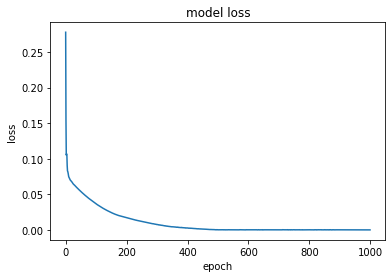

In [ ]:
# Train model
training_loss = []
#training_ci = []
for epoch in range(N_epochs):
  lr = adjust_learning_rate(optimizer, epoch, learning_rate,lr_decay_rate)
  # Predictions
  y_train_pred = model(x_train)
  loss = loss_function(y_train_pred, y_train, E2_train, model)
  training_loss.append(loss)
  #training_ci.append(concordance_index(T_true, y_pred.detach().numpy(), E2))

  # Parameter update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

# Validate model
with torch.no_grad():
  y_val_pred = model(x_val)
  validation_loss = loss_function(y_val_pred, y_val, E2_val, model)

# Plot training loss
plt.plot(training_loss)
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

# Print final results
ci = concordance_index(y_train, -y_train_pred.detach().numpy(), E2_train)
print("\nConcordance index of training data:", ci)
ci_val = concordance_index(y_val, -y_val_pred.detach().numpy(), E2_val)
print("Concordance index of validation data:", ci_val, "\n")
print(y_train_pred[:20])
print("Training loss in last epoch:", training_loss[-1].item())
print("Validation loss:", validation_loss.item())

# Print the parameters that were used
print("\nParamters used for this network:")
print("# dense layers", len(N_nodes_hidden))
print("# Nodes/layer", N_nodes_hidden[0])
print("Learning rate", learning_rate)
print("L2 reg", l2_reg)
print("Dropout rate", r_dropout)
print("LR decay", lr_decay_rate)
print(model)